In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns


In [2]:
# Load your CSV file
data = pd.read_excel('data.xlsx')  # Replace with your actual filename

# Generating features 

In [17]:
resolution_m = 60e-6 #m
resolution_cm = 60e-4 #cm
sample_size_pixel = 400
sample_length_cm = resolution_cm * sample_size_pixel

data['cluster_density'] = data['num_cluster'] / (sample_length_cm**3)
data['pore_density'] = data['num_pores'] / (sample_length_cm**3)
data['throat_density'] = data['num_throats'] / (sample_length_cm**3)
data['anisotropy_MIL'] = (data['MIL_x'] + data['MIL_y']) / (2*data['MIL_z'])
data['anisotropy_Perm'] = (data['Perm_x'] + data['Perm_y']) / (2*data['Perm_z'])
data['anisotropy_Tort'] = (data['Tort_x'] + data['Tort_y']) / (2*data['Tort_z'])
data['avg_pore_diameter'] = data['avg_pore_diameter'] * 1e6
data['avg_throat_diameter'] = data['avg_throat_diameter'] * 1e6
data['density'] = (1- (data['porosity']/100)) * 0.917 # density g/cm3
data['D_eff__by__D_air'] = (data['porosity']/100)/data['Tort_z'] # Normalized diffusivity
data['log_perm_z'] = np.log10(data['Perm_z'])
data['log_log_perm_z'] = np.log10(data['log_perm_z'])
data.columns

D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'pore_density', 'throat_density',
       'anisotropy_MIL', 'anisotropy_Perm', 'anisotropy_Tort', 'density',
       'D_eff__by__D_air', 'log_perm_z', 'log_log_perm_z'],
      dtype='object')

# Densification and pore network features

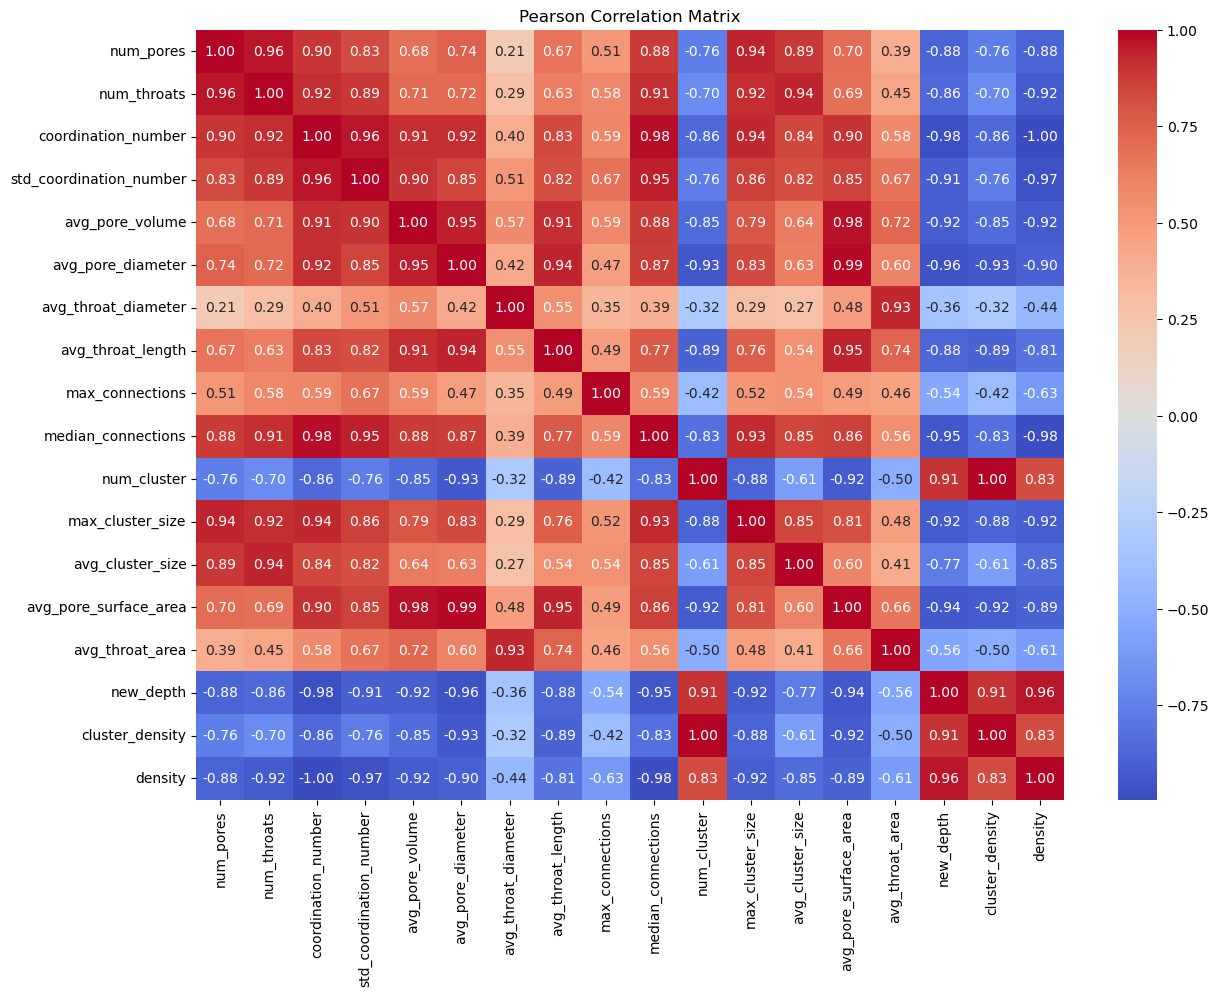

'\n# Plot Spearman correlation\nplt.figure(figsize=(14, 10))\nsns.heatmap(corr_spearman, annot=True, cmap=\'coolwarm\', fmt=".2f")\nplt.title(\'Spearman Correlation Matrix\')\nplt.show()'

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = [
    'num_pores', 'num_throats', 'coordination_number',
    'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
    'avg_throat_diameter', 'avg_throat_length', 'max_connections',
    'median_connections', 'num_cluster', 'max_cluster_size',
    'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
    'new_depth', 'cluster_density','density'
]

df = data.copy()
#df = df[df["Perm_z"] > 5e-14]
#df = df[df["Perm_z"] < 5e-6]
X = df[features].dropna()

density = df['new_depth'].loc[X.index]

# === Correlation Matrices ===
corr_pearson = X.corr(method='pearson')
corr_spearman = X.corr(method='spearman')

# Plot Pearson correlation
plt.figure(figsize=(14, 10))
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Matrix')
plt.show()
'''
# Plot Spearman correlation
plt.figure(figsize=(14, 10))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Matrix')
plt.show()'''



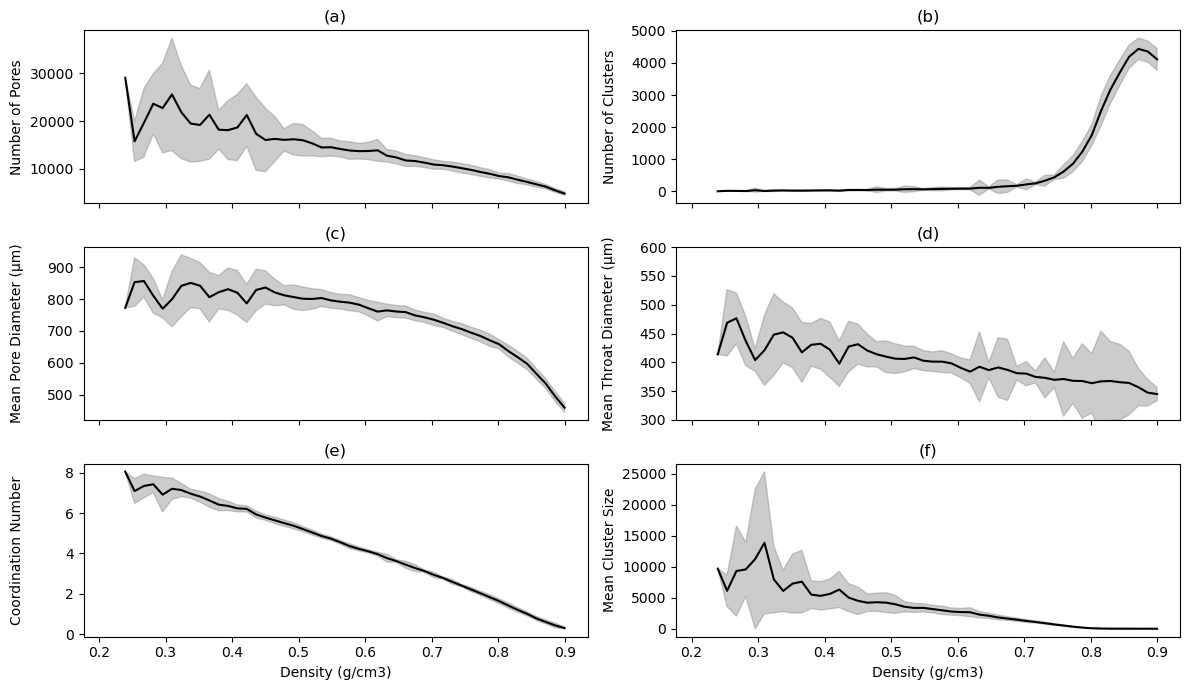

In [15]:

from scipy.stats import binned_statistic


# Bin the data (optional: change number of bins as needed)
def plot_avg(x,y):
    num_bins = 50
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_std, _, _ = binned_statistic(x, y, statistic='std', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    return bin_centers , bin_means,bin_std
# Bin centers


fig, axes = plt.subplots(3, 2,sharex='col', figsize=(12, 7))

x , y = df['density'], df['pore_density']
bin_centers , bin_means,bin_std = plot_avg(x,y)

axes[0,0].plot(bin_centers, bin_means, label='Mean of y', color='black')
axes[0,0].fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color='gray', alpha=0.4, label='±1 std dev')
#axes[0,0].set_xlabel('Density (g/cm3)')
axes[0,0].set_ylabel('Number of Pores')
axes[0,0].set_title('(a)')


x , y = df['density'], df['num_cluster']
bin_centers , bin_means,bin_std = plot_avg(x,y)

axes[0,1].plot(bin_centers, bin_means, label='Mean of y', color='black')
axes[0,1].fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color='gray', alpha=0.4, label='±1 std dev')
#axes[0,1].set_xlabel('Density (g/cm3)')
axes[0,1].set_ylabel('Number of Clusters')
axes[0,1].set_title('(b)')



x , y = df['density'], df['avg_pore_diameter']
bin_centers , bin_means,bin_std = plot_avg(x,y)

axes[1,0].plot(bin_centers, bin_means, label='Mean of y', color='black')
axes[1,0].fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color='gray', alpha=0.4, label='±1 std dev')
#axes[1,0].set_xlabel('Density (g/cm3)')
axes[1,0].set_ylabel('Mean Pore Diameter (μm)')
axes[1,0].set_title('(c)')


x , y = df['density'], df['avg_throat_diameter']
bin_centers , bin_means,bin_std = plot_avg(x,y)

axes[1,1].plot(bin_centers, bin_means, label='Mean of y', color='black')
axes[1,1].fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color='gray', alpha=0.4, label='±1 std dev')
#axes[1,1].set_xlabel('Density (g/cm3)')
axes[1,1].set_ylabel('Mean Throat Diameter (μm)')
axes[1,1].set_ylim(300,600)
axes[1,1].set_title('(d)')



x , y = df['density'], df['coordination_number']
bin_centers , bin_means,bin_std = plot_avg(x,y)

axes[2,0].plot(bin_centers, bin_means, label='Mean of y', color='black')
axes[2,0].fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color='gray', alpha=0.4, label='±1 std dev')
axes[2,0].set_xlabel('Density (g/cm3)')
axes[2,0].set_ylabel('Coordination Number')
axes[2,0].set_title('(e)')


x , y = df['density'], df['avg_cluster_size']
bin_centers , bin_means,bin_std = plot_avg(x,y)

axes[2,1].plot(bin_centers, bin_means, label='Mean of y', color='black')
axes[2,1].fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color='gray', alpha=0.4, label='±1 std dev')
axes[2,1].set_xlabel('Density (g/cm3)')
axes[2,1].set_ylabel('Mean Cluster Size')
axes[2,1].set_title('(f)')

fig.align_ylabels()
plt.tight_layout()
plt.savefig('density_network.png',dpi=400)
plt.show()

Top feature loadings for PC1 and PC2:
                              PC1       PC2       PC3
coordination_number      0.264268 -0.085056  0.028936
median_connections       0.257847 -0.104280  0.074085
std_coordination_number  0.255684  0.014183  0.182871
avg_pore_diameter        0.252422  0.068637 -0.266209
avg_pore_volume          0.252016  0.175045 -0.087209
avg_pore_surface_area    0.251094  0.131818 -0.245095
max_cluster_size         0.250422 -0.192723 -0.006400
avg_throat_length        0.239733  0.218713 -0.221122
num_throats              0.236833 -0.253139  0.260893
num_pores                0.234901 -0.288208  0.116820
avg_cluster_size         0.217238 -0.264315  0.332578
avg_throat_area          0.177517  0.518417  0.210660
max_connections          0.164611  0.031630  0.427688
avg_throat_diameter      0.129597  0.590204  0.290787
num_cluster             -0.241217  0.016254  0.352389
cluster_density         -0.241217  0.016254  0.352389
new_depth               -0.261854  0.069821 

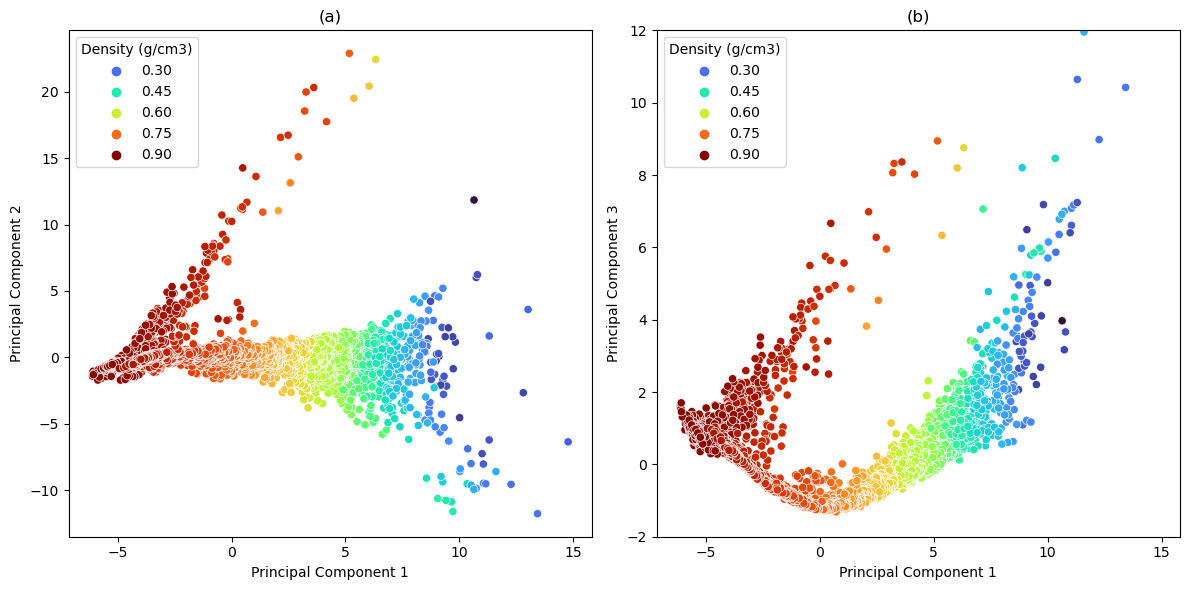

In [16]:
# === PCA Analysis ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()

# Scree Plot
'''plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var)+1), cumulative_var, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()'''

# PCA Loadings (feature contribution to components)
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(features))], index=features)
print("Top feature loadings for PC1 and PC2:")
print(loadings[['PC1', 'PC2', 'PC3']].sort_values('PC1', ascending=False))

# === PCA Scatter Plot ===
pca_df = pd.DataFrame(pca_result[:, :3], columns=['PC1', 'PC2','PC3'])
pca_df['density'] = df['density'].values

# Add new_depth to pca_df for coloring
pca_df['new_depth'] = X['new_depth'].values

# Create the 2x2 subplot figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: PC1 vs PC2 colored by density
sns.scatterplot(ax=axes[0], data=pca_df, x='PC1', y='PC2', hue='density', palette='turbo')
axes[0].set_title('(a)')
axes[0].legend(title='Density (g/cm3)', loc='upper left')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

# Plot 2: PC1 vs PC3 colored by density
sns.scatterplot(ax=axes[1], data=pca_df, x='PC1', y='PC3', hue='density', palette='turbo')
axes[1].set_title('(b)')
axes[1].legend(title='Density (g/cm3)', loc='upper left')
axes[1].set_ylim(-2,12)
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 3')

plt.tight_layout()
plt.savefig('PCA.png',dpi=400)
plt.show()




In [50]:
data.columns


Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'pore_density', 'throat_density',
       'anisotropy_MIL', 'anisotropy_Perm', 'anisotropy_Tort', 'density',
       'D_eff__by__D_air', 'log_perm_z', 'log_log_perm_z'],
      dtype='object')

In [141]:
data['log_perm_z']

0      -25.376001
1            -inf
2            -inf
3            -inf
4            -inf
          ...    
9261    -8.005593
9262    -7.874588
9263    -7.901708
9264    -7.896668
9265    -7.869841
Name: log_perm_z, Length: 9266, dtype: float64

In [82]:
# Bin depth into 1m intervals
df = data.sort_values(by="new_depth").copy()

# Features of interest
features_interest = ['coordination_number', 'cluster_density','anisotropy_MIL', 'SSA','pore_density','throat_density']

df_corr_depth = pd.DataFrame(columns=features_interest)
bin_size = 1  # meters per bin
df['Depth_bin'] = (df['new_depth'] // bin_size) * bin_size

df_corr_depth['Depth_bin'] = np.array([i+1 for i in range(int(df['Depth_bin'].max()))])
                                 
for feature in features_interest:
    for depth, group in df.groupby('Depth_bin'):
        if len(group) > 1:  # need at least 2 points to compute correlation
            r = group['Perm_z'].corr(group[feature])
            df_corr_depth.loc[df_corr_depth['Depth_bin'] == depth, feature] = r
            

In [151]:
# Bin depth into 1m intervals
df = data.sort_values(by="porosity").copy()

df_corr_porosity = pd.DataFrame(columns=features_interest)
bin_size = 1  # meters per bin
df['porosity_bin'] = (df['porosity'] // bin_size) * bin_size

df_corr_porosity['porosity_bin'] = np.array([i+1 for i in range(int(df['porosity_bin'].max()))])
                                 
for feature in features_interest:
    for p, group in df.groupby('porosity_bin'):
        if len(group) > 1:  # need at least 2 points to compute correlation
            r = group['Perm_z'].corr(group[feature])
            df_corr_porosity.loc[df_corr_porosity['porosity_bin'] == p, feature] = r
            




In [152]:
df_corr_porosity = df_corr_porosity.dropna()

In [183]:
paper_colors = [
    '#4477AA',  # Blue
    '#d20015',  # Red
    '#ffd700',  # Yellow
    '#117733',  # Green
    '#332288',  # Dark Blue
    '#AA4499',  # Purple
    '#b967ff',  # Cyan
    '#999933',  # Olive
    '#882255',  # Dark Red
    '#8c6b57'   # Brown
]
colors = {feature: paper_colors[i % len(paper_colors)] for i, feature in enumerate(features_interest)}

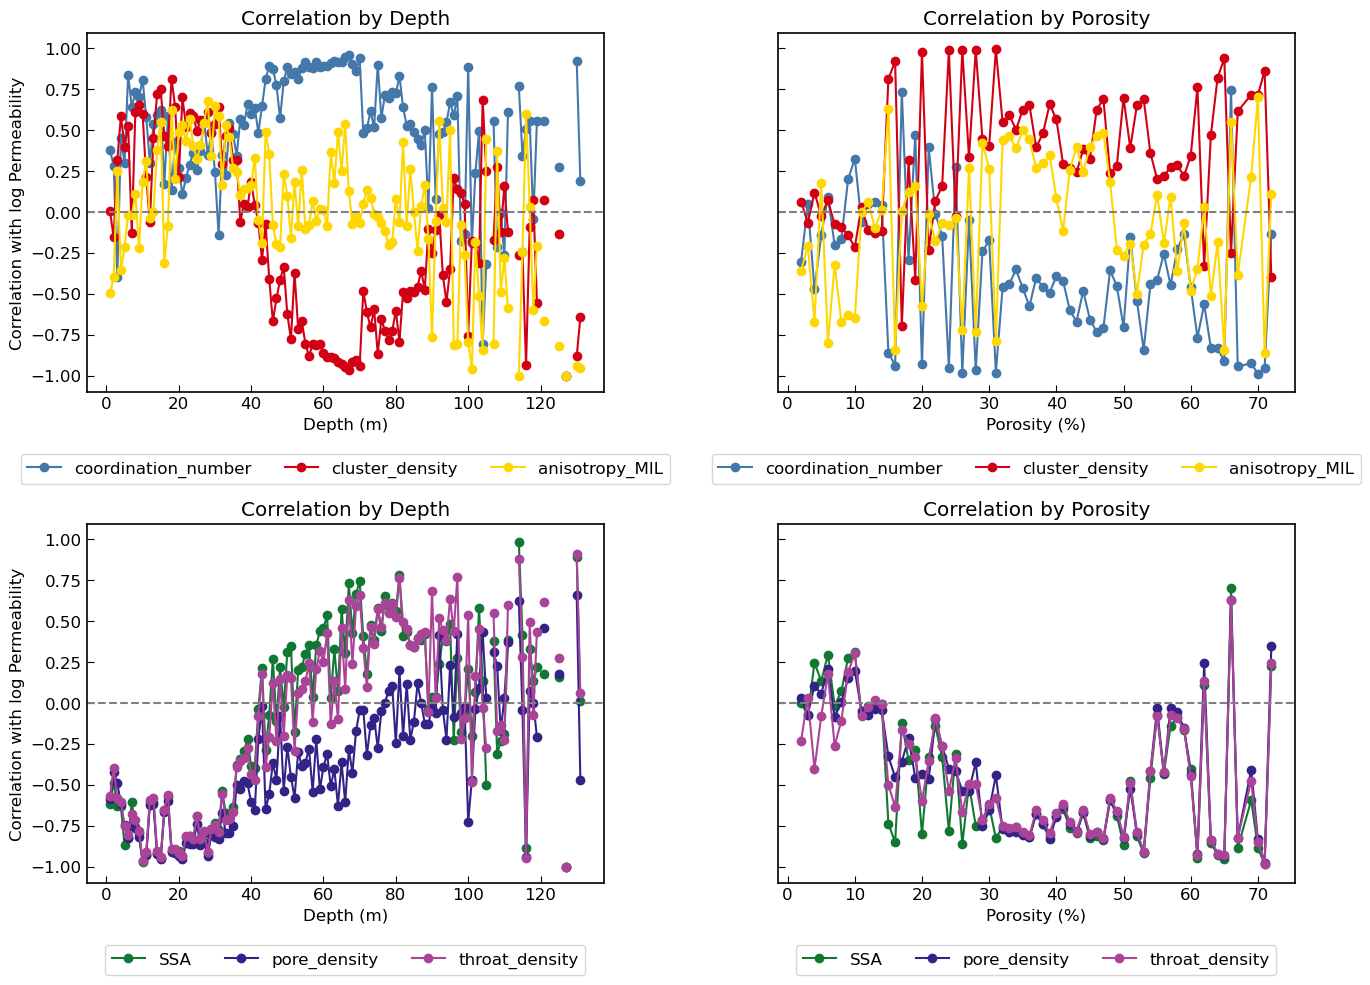

In [184]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

# First 3 features - Depth
for feature in features_interest[:3]:
    axes[0, 0].plot(df_corr_depth['Depth_bin'], df_corr_depth[feature],
                    marker='o', label=feature, color=colors[feature])
axes[0, 0].set_xlabel('Depth (m)')
axes[0, 0].axhline(y=0, linestyle='--', color='gray')
axes[0, 0].set_ylabel('Correlation with log Permeability')
axes[0, 0].set_title('Correlation by Depth')
axes[0, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# First 3 features - Porosity
for feature in features_interest[:3]:
    axes[0, 1].plot(df_corr_porosity['porosity_bin'], df_corr_porosity[feature],
                    marker='o', label=feature, color=colors[feature])
axes[0, 1].set_xlabel('Porosity (%)')
axes[0, 1].axhline(y=0, linestyle='--', color='gray')
axes[0, 1].set_title('Correlation by Porosity')
axes[0, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Remaining features - Depth
for feature in features_interest[3:]:
    axes[1, 0].plot(df_corr_depth['Depth_bin'], df_corr_depth[feature],
                    marker='o', label=feature, color=colors[feature])
axes[1, 0].set_xlabel('Depth (m)')
axes[1, 0].axhline(y=0, linestyle='--', color='gray')
axes[1, 0].set_ylabel('Correlation with log Permeability')
axes[1, 0].set_title('Correlation by Depth')
axes[1, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Remaining features - Porosity
for feature in features_interest[3:]:
    axes[1, 1].plot(df_corr_porosity['porosity_bin'], df_corr_porosity[feature],
                    marker='o', label=feature, color=colors[feature])
axes[1, 1].set_xlabel('Porosity (%)')
axes[1, 1].axhline(y=0, linestyle='--', color='gray')
axes[1, 1].set_title('Correlation by Porosity')
axes[1, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.tight_layout()
plt.show()


In [185]:
# Bin depth into 1m intervals

df = data.sort_values(by="new_depth").copy()


df = df[df['Perm_z'] > 0]
# Features of interest
features_interest = ['coordination_number', 'cluster_density','anisotropy_MIL', 'SSA','pore_density','throat_density']

df_corr_depth_log_perm = pd.DataFrame(columns=features_interest)
bin_size = 1  # meters per bin
df['Depth_bin'] = (df['new_depth'] // bin_size) * bin_size

df_corr_depth_log_perm['Depth_bin'] = np.array([i+1 for i in range(int(df['Depth_bin'].max()))])
                                 
for feature in features_interest:
    for depth, group in df.groupby('Depth_bin'):
        if len(group) > 1:  # need at least 2 points to compute correlation
            r = group['log_perm_z'].corr(group[feature])
            df_corr_depth_log_perm.loc[df_corr_depth_log_perm['Depth_bin'] == depth, feature] = r

In [180]:
df_corr_depth

coordination_number cluster_density anisotropy_MIL       SSA pore_density  \
0              0.377466        0.003832      -0.496287 -0.614411    -0.584745   
1              0.284417       -0.154908      -0.394932  -0.48565     -0.42093   
2             -0.393794        0.315505       0.248149 -0.625203    -0.487688   
3              0.453239        0.588622      -0.354288 -0.629544    -0.615328   
4                0.3017        0.398156        -0.2121  -0.86822    -0.746103   
..                  ...             ...            ...       ...          ...   
126                -1.0            -1.0           -1.0      -1.0         -1.0   
127                 NaN             NaN            NaN       NaN          NaN   
128                 NaN             NaN            NaN       NaN          NaN   
129            0.919836        -0.88107      -0.936744  0.893785     0.657889   
130            0.188235       -0.642334      -0.948759  0.011182    -0.466901   

    throat_density  Depth_bin  
0        -0.567541          1  
1        -0.398257          2  
2        -0.576356          3  
3        -0.602912          4  
4        -0.750426          5  
..             ...        ...  
126           -1.0        127  
127            NaN        128  
128            NaN        129  
129       0.909974        130  
130       0.059393        131  

[131 rows x 7 columns]

# Permeability and Tortuosity feature correlation

In [18]:
df_fit = data[data["new_depth"]<80].copy()

df_fit = df_fit.drop(columns = ['name', 'number_of_regions', 'starting_layer', 'ending_layer','depth','sample_volume',
                               'num_pores','num_throats'])

df_fit = df_fit.drop(columns = ['MIL_y','MIL_x','Tort_x','Tort_y','Perm_x','Perm_y','num_cluster',
                                'max_connections','max_cluster_size','anisotropy_Perm','anisotropy_Tort'
                               ,'avg_throat_diameter','avg_pore_diameter'])

df_fit = df_fit[df_fit["Perm_z"] > 5e-14]
df_fit = df_fit[df_fit["Perm_z"] < 5e-6]

df_fit = df_fit[df_fit["Tort_z"] > 1]
df_fit = df_fit[df_fit["Tort_z"] < 500]



In [19]:
print('old column names = ',df_fit.columns)

old column names =  Index(['porosity', 'open_pores', 'cuted_pores', 'isolated_pores',
       'euler_density', 'SSA', 'MIL_z', 'Perm_z', 'Tort_z', 'sph_ice_cluster',
       'coordination_number', 'std_coordination_number', 'avg_pore_volume',
       'avg_throat_length', 'median_connections', 'avg_cluster_size',
       'avg_pore_surface_area', 'avg_throat_area', 'new_depth',
       'cluster_density', 'pore_density', 'throat_density', 'anisotropy_MIL',
       'density', 'D_eff__by__D_air', 'log_perm_z', 'log_log_perm_z'],
      dtype='object')


In [22]:
# Compute the correlation matrix
rename_map = {
'porosity':'Porosity',
'open_pores':'Open Porosity',
'cuted_pores':'Cuted Porosity',
'isolated_pores':'Isolated Porosity',
'euler_density':'Euler Density',
'SSA':'SSA',
'MIL_z':'MIL',
'Perm_z':'Permeability',
'Tort_z':'Tortuosity',
'sph_ice_cluster':'Spherical Ice Cluster',
'coordination_number':'Coordination Num',
'std_coordination_number':'SD Coordination Num', 
'avg_pore_volume':'Mean Pore Volume',
'avg_throat_length':'Mean Throat Length',
'median_connections':'Median Num Connections', 
'avg_cluster_size':'Mean Cluster Size',
'avg_pore_surface_area':'Mean Pore Surface Area',
'avg_throat_area':'Mean Throat Area',
'new_depth':'Depth',
'cluster_density':'Cluster Density', 
'pore_density':'Pore Density',
'throat_density':'Throat Density',
'anisotropy_MIL':'Anisotropy MIL',
'density':'Density',
'D_eff__by__D_air':'Normalized Diffusivity',
'log_perm_z':'log Permeability',
'log_log_perm_z':'log log Permeability'
}

df_fit = df_fit.rename(columns=rename_map)

corr_matrix = df_fit.corr()
corr_matrix

Porosity  Open Porosity  Cuted Porosity  \
Porosity                1.000000       0.997091       -0.520073   
Open Porosity           0.997091       1.000000       -0.583342   
Cuted Porosity         -0.520073      -0.583342        1.000000   
Isolated Porosity      -0.511118      -0.574491        0.978854   
Euler Density          -0.776408      -0.788099        0.558795   
SSA                     0.895395       0.906256       -0.615887   
MIL                    -0.923498      -0.943177        0.729537   
Permeability            0.140454       0.135674       -0.024012   
Tortuosity             -0.391341      -0.451569        0.879357   
Spherical Ice Cluster  -0.949697      -0.957063        0.607548   
Coordination Num        0.995782       0.995597       -0.547806   
SD Coordination Num     0.995700       0.991270       -0.501291   
Mean Pore Volume        0.799136       0.802647       -0.480092   
Mean Throat Length      0.705421       0.722349       -0.577644   
Median Num Connections  0.967129       0.965802       -0.519438   
Mean Cluster Size       0.796569       0.792275       -0.391896   
Mean Pore Surface Area  0.718924       0.731553       -0.536862   
Mean Throat Area        0.791690       0.793751       -0.460352   
Depth                  -0.968500      -0.974423        0.601973   
Cluster Density        -0.694625      -0.743560        0.922680   
Pore Density            0.733651       0.731457       -0.381401   
Throat Density          0.868660       0.861552       -0.400377   
Anisotropy MIL         -0.723115      -0.710813        0.262174   
Density                -1.000000      -0.997091        0.520073   
Normalized Diffusivity  0.969626       0.957453       -0.399972   
log Permeability        0.884756       0.913123       -0.801188   
log log Permeability         NaN            NaN             NaN   

                        Isolated Porosity  Euler Density       SSA       MIL  \
Porosity                        -0.511118      -0.776408  0.895395 -0.923498   
Open Porosity                   -0.574491      -0.788099  0.906256 -0.943177   
Cuted Porosity                   0.978854       0.558795 -0.615887  0.729537   
Isolated Porosity                1.000000       0.553289 -0.607875  0.721911   
Euler Density                    0.553289       1.000000 -0.962474  0.871859   
SSA                             -0.607875      -0.962474  1.000000 -0.958068   
MIL                              0.721911       0.871859 -0.958068  1.000000   
Permeability                    -0.023452      -0.035568  0.029424 -0.075853   
Tortuosity                       0.897273       0.420185 -0.465544  0.563369   
Spherical Ice Cluster            0.597460       0.898369 -0.976180  0.967414   
Coordination Num                -0.539666      -0.815621  0.925974 -0.941980   
SD Coordination Num             -0.491013      -0.739772  0.868812 -0.907425   
Mean Pore Volume                -0.474452      -0.395124  0.558180 -0.723336   
Mean Throat Length              -0.573718      -0.363865  0.521454 -0.709807   
Median Num Connections          -0.511103      -0.806650  0.910867 -0.921241   
Mean Cluster Size               -0.385516      -0.793635  0.821877 -0.742958   
Mean Pore Surface Area          -0.533506      -0.369364  0.527431 -0.706265   
Mean Throat Area                -0.453437      -0.388219  0.555528 -0.712415   
Depth                            0.591394       0.855611 -0.951485  0.973207   
Cluster Density                  0.933650       0.728560 -0.790154  0.881538   
Pore Density                    -0.373526      -0.899084  0.870053 -0.730950   
Throat Density                  -0.393255      -0.864940  0.891665 -0.798439   
Anisotropy MIL                   0.255950       0.501600 -0.634480  0.611421   
Density                          0.511118       0.776408 -0.895395  0.923498   
Normalized Diffusivity          -0.391202      -0.665485  0.805958 -0.827859   
log Permeability                -0.803328      -0.773916  0.873187 

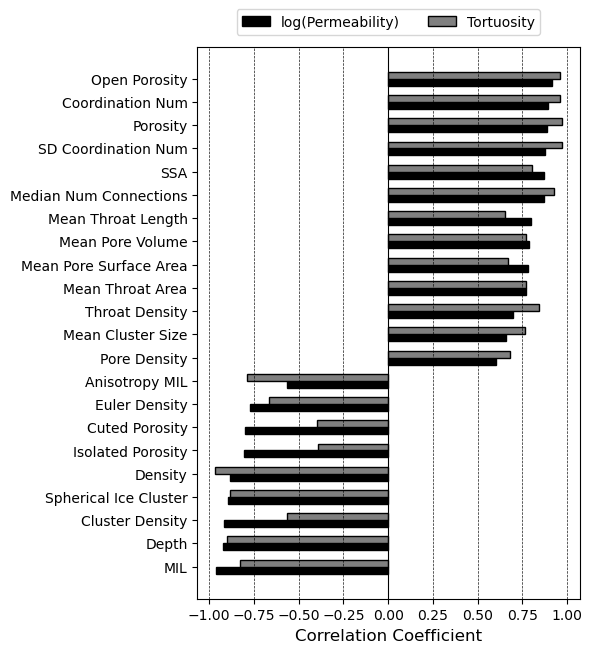

In [28]:
# Get correlations for Perm_z and Tort_z (excluding self-correlations)
features = corr_matrix.columns.drop(['Permeability', 'Tortuosity', 'Normalized Diffusivity','log log Permeability','log Permeability'])
perm_corr = corr_matrix.loc[features,'log Permeability']
tort_corr = corr_matrix.loc[features, 'Normalized Diffusivity']

features_sorted = perm_corr.sort_values().index
perm_sorted = perm_corr[features_sorted]
tort_sorted = tort_corr[features_sorted]


# Plotting
fig, ax = plt.subplots(figsize=(6, len(features_sorted) * 0.3))  # Portrait layout

bar_width = 0.3
indices = np.arange(len(features_sorted))

# Colorblind-safe colors
perm_color = 'black'   # Blue
tort_color = 'gray'   # Orange

# Horizontal bars
ax.barh(indices - bar_width/2, perm_sorted, height=bar_width, color=perm_color, edgecolor='black', label='log(Permeability)')
ax.barh(indices + bar_width/2, tort_sorted, height=bar_width, color=tort_color, edgecolor='black', label='Tortuosity')

# Labels and aesthetics
ax.set_yticks(indices)
ax.set_yticklabels(features_sorted, fontsize=10,color='black')
ax.set_xlabel('Correlation Coefficient', fontsize=12)
#ax.set_title('Correlation of Features with Perm_z and Tort_z', fontsize=13)

# Gridlines and axis styling
ax.grid(axis='x', linestyle='--', color='black', linewidth=0.5, alpha=0.9)
ax.axvline(0, color='black', linewidth=0.8)
ax.tick_params(axis='x', labelsize=10)

# Legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=2, frameon=True, fontsize=10)
plt.tight_layout()
#plt.savefig('correlation_perm_tort.png',dpi=300)
plt.show()

In [7]:
df_fit.columns

Index(['Porosity', 'Open Porosity', 'Cuted Porosity', 'Isolated Porosity',
       'Euler Density', 'SSA', 'MIL', 'Permeability', 'Tortuosity',
       'Spherical Ice Cluster', 'Num Pores', 'Num Throats', 'Coordination Num',
       'SD Coordination Num', 'Mean Pore Volume', 'Mean Throat Length',
       'Median Num Connections', 'Mean Cluster Size', 'Mean Pore Surface Area',
       'Mean Throat Area', 'Depth', 'Cluster Density', 'Anisotropy MIL',
       'Density', 'Normalized Diffusivity'],
      dtype='object')

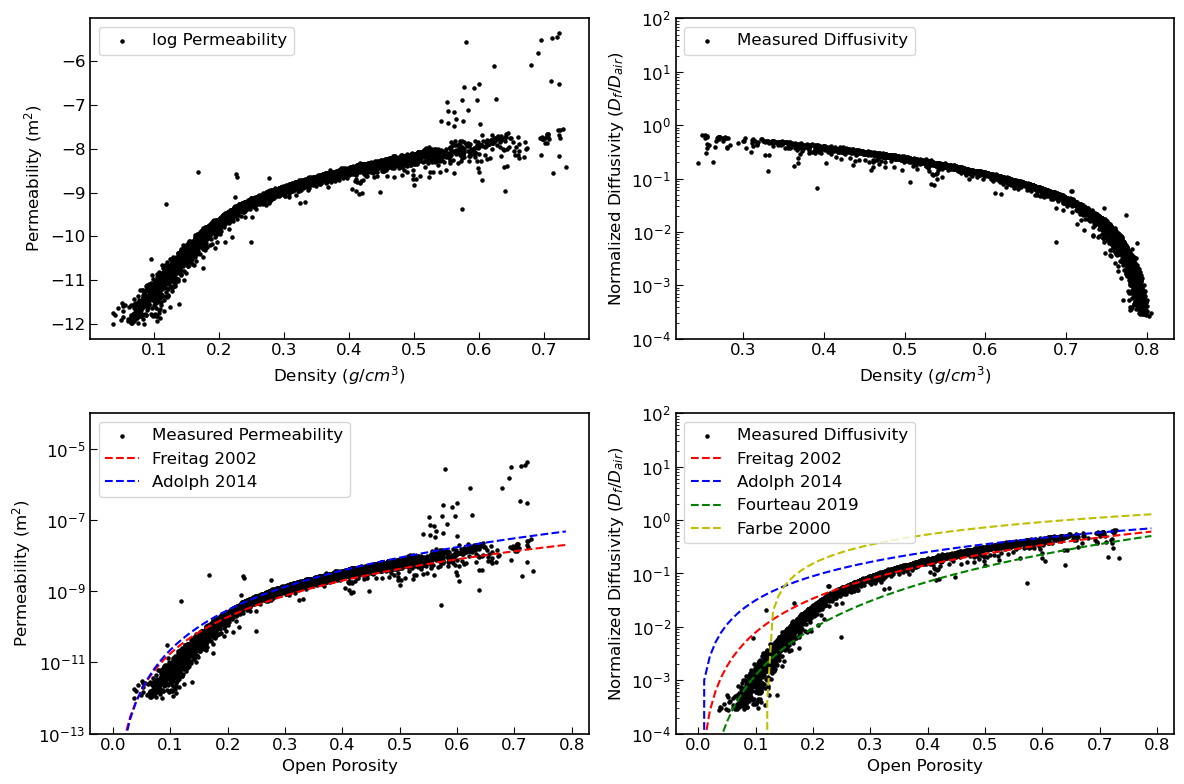

In [34]:

df = df_fit.copy()

x = df_fit['Porosity']/100     
y1 = df_fit['log Permeability'] # First y-axis data
y2 = df_fit['Normalized Diffusivity']       # Second y-axis data

pr = np.array(list(range(80)))/100 #for drawing line in open porosity

# Define models
def freitag_perm_model(p): return 10**-7.7 * (1.5**2) * p**3.4
def adolph_perm_model(p): return 10**-7.29 * (1.5**2) * p**3.71

#m=1.5
freitag_perm =  freitag_perm_model(pr)
adolph_perm = adolph_perm_model(pr)

freitag_def =  pr**2.1
adolph_def= pr**1.5
fourteau_def= pr**2.9
farbe_def = 1.92*pr-0.23

freitag_diffusivity = pr**2.9
freitag_diffusivity = 1.7*(df_fit['Open Porosity']/100) -0.2

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

s1 = 5  # marker size

# Create one figure with two subplots side-by-side
fig, ((ax1, ax2), (ax3 , ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# — Plot 1: Permeability —
ax1.scatter(df_fit['Open Porosity']/100, y1, label='log Permeability', color='black', s=s1)
ax1.set_xlabel('Density ($g/cm^{3}$)')
ax1.set_ylabel(r'Permeability ($\mathrm{m}^2$)', color='black')
#ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')
#ax1.set_title('Permeability')
#ax1.set_ylim(10e-14,10e-5)

# — Plot 2: Diffusivity —
ax2.scatter(df_fit['Density'], y2, label='Measured Diffusivity', color='black', s=s1)
#ax2.plot(x, freitag_diffusivity, '--', label='Freitag 2002', color='r')

ax2.set_xlabel('Density ($g/cm^{3}$)')
ax2.set_ylabel(r'Normalized Diffusivity ($D_f/D_{air}$)', color='black')
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper left')
#ax2.set_title('Diffusivity vs. Porosity')
ax2.set_ylim(1e-4,10e1)


y1 = df_fit['Permeability']

# — Plot 3: Permeability —
ax3.scatter(df_fit['Open Porosity']/100, y1, label='Measured Permeability', color='black', s=s1)
ax3.plot(pr, freitag_perm, '--', label='Freitag 2002', color='r')
ax3.plot(pr, adolph_perm, '--', label='Adolph 2014', color='b')

ax3.set_xlabel('Open Porosity')
ax3.set_ylabel(r'Permeability ($\mathrm{m}^2$)', color='black')
ax3.set_yscale('log')
ax3.tick_params(axis='y', labelcolor='black')
ax3.legend(loc='upper left')
#ax1.set_title('Permeability')
ax3.set_ylim(10e-14,10e-5)

# — Plot 4: Diffusivity —
ax4.scatter(df_fit['Open Porosity']/100, y2, label='Measured Diffusivity', color='black', s=s1)
ax4.plot(pr, freitag_def, '--', label='Freitag 2002', color='r')
ax4.plot(pr, adolph_def, '--', label='Adolph 2014', color='b')
ax4.plot(pr, fourteau_def, '--', label='Fourteau 2019', color='g')
ax4.plot(pr, farbe_def, '--', label='Farbe 2000', color='y')

ax4.set_xlabel('Open Porosity')
ax4.set_ylabel(r'Normalized Diffusivity ($D_f/D_{air}$)', color='black')
ax4.set_yscale('log')
ax4.tick_params(axis='y', labelcolor='black')
ax4.legend(loc='upper left')
#ax2.set_title('Diffusivity vs. Porosity')
ax4.set_ylim(1e-4,10e1)




plt.tight_layout()
#plt.savefig("perm_defus_open_porosity.png", dpi=400, bbox_inches='tight')
plt.show()

In [9]:
from sklearn.metrics import r2_score, mean_squared_error


In [12]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Extract open porosity
df_fit = df_fit[df_fit['Open Porosity']>0]
porosity_open = df_fit['Open Porosity'] / 100

# -------------------------
# Interpolate model values to measurement points
# -------------------------

# Define models
def freitag_perm_model(p): return 10**-7.7 * (1.5**2) * p**3.4
def adolph_perm_model(p): return 10**-7.29 * (1.5**2) * p**3.71

def freitag_def_model(p): return p**2.1
def adolph_def_model(p): return p**1.5
def fourteau_def_model(p): return p**2.9
def farbe_def_model(p): return 1.92 * p - 0.23

# Compute model values at same porosity as data
freitag_perm_pred = freitag_perm_model(porosity_open)
adolph_perm_pred = adolph_perm_model(porosity_open)

freitag_def_pred = freitag_def_model(porosity_open)
adolph_def_pred = adolph_def_model(porosity_open)
fourteau_def_pred = fourteau_def_model(porosity_open)
farbe_def_pred = farbe_def_model(porosity_open)

# True values
y_perm_true = df_fit['Permeability'].values
y_def_true = df_fit['Normalized Diffusivity'].values

# -------------------------
# Metrics
# -------------------------
def print_log_metrics(name, y_true, y_pred):
    mask = (y_true > 0) & (y_pred > 0)
    y_true_log = np.log10(y_true[mask])
    y_pred_log = np.log10(y_pred[mask])
    r2 = r2_score(y_true_log, y_pred_log)
    rmse = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    print(f"{name} (log-scale):\n  R² = {r2:.4f}\n  RMSE = {rmse:.4f} (log10 units)")
    

print("=== Permeability Models ===")
print_log_metrics("Freitag 2002", y_perm_true, freitag_perm_pred)
print_log_metrics("Adolph 2014", y_perm_true, adolph_perm_pred)

print("\n=== Diffusivity Models ===")
print_log_metrics("Freitag 2002", y_def_true, freitag_def_pred)
print_log_metrics("Adolph 2014", y_def_true, adolph_def_pred)
print_log_metrics("Fourteau 2019", y_def_true, fourteau_def_pred)
print_log_metrics("Farbe 2000", y_def_true, farbe_def_pred)


=== Permeability Models ===
Freitag 2002 (log-scale):
  R² = 0.9051
  RMSE = 0.2700 (log10 units)
Adolph 2014 (log-scale):
  R² = 0.9126
  RMSE = 0.2592 (log10 units)

=== Diffusivity Models ===
Freitag 2002 (log-scale):
  R² = 0.8071
  RMSE = 0.2980 (log10 units)
Adolph 2014 (log-scale):
  R² = 0.2326
  RMSE = 0.5943 (log10 units)
Fourteau 2019 (log-scale):
  R² = 0.6946
  RMSE = 0.3749 (log10 units)
Farbe 2000 (log-scale):
  R² = -0.5143
  RMSE = 0.6700 (log10 units)


In [32]:
df_fit['log log Permeability']

734    NaN
735    NaN
736    NaN
737    NaN
738    NaN
        ..
9261   NaN
9262   NaN
9263   NaN
9264   NaN
9265   NaN
Name: log log Permeability, Length: 5419, dtype: float64

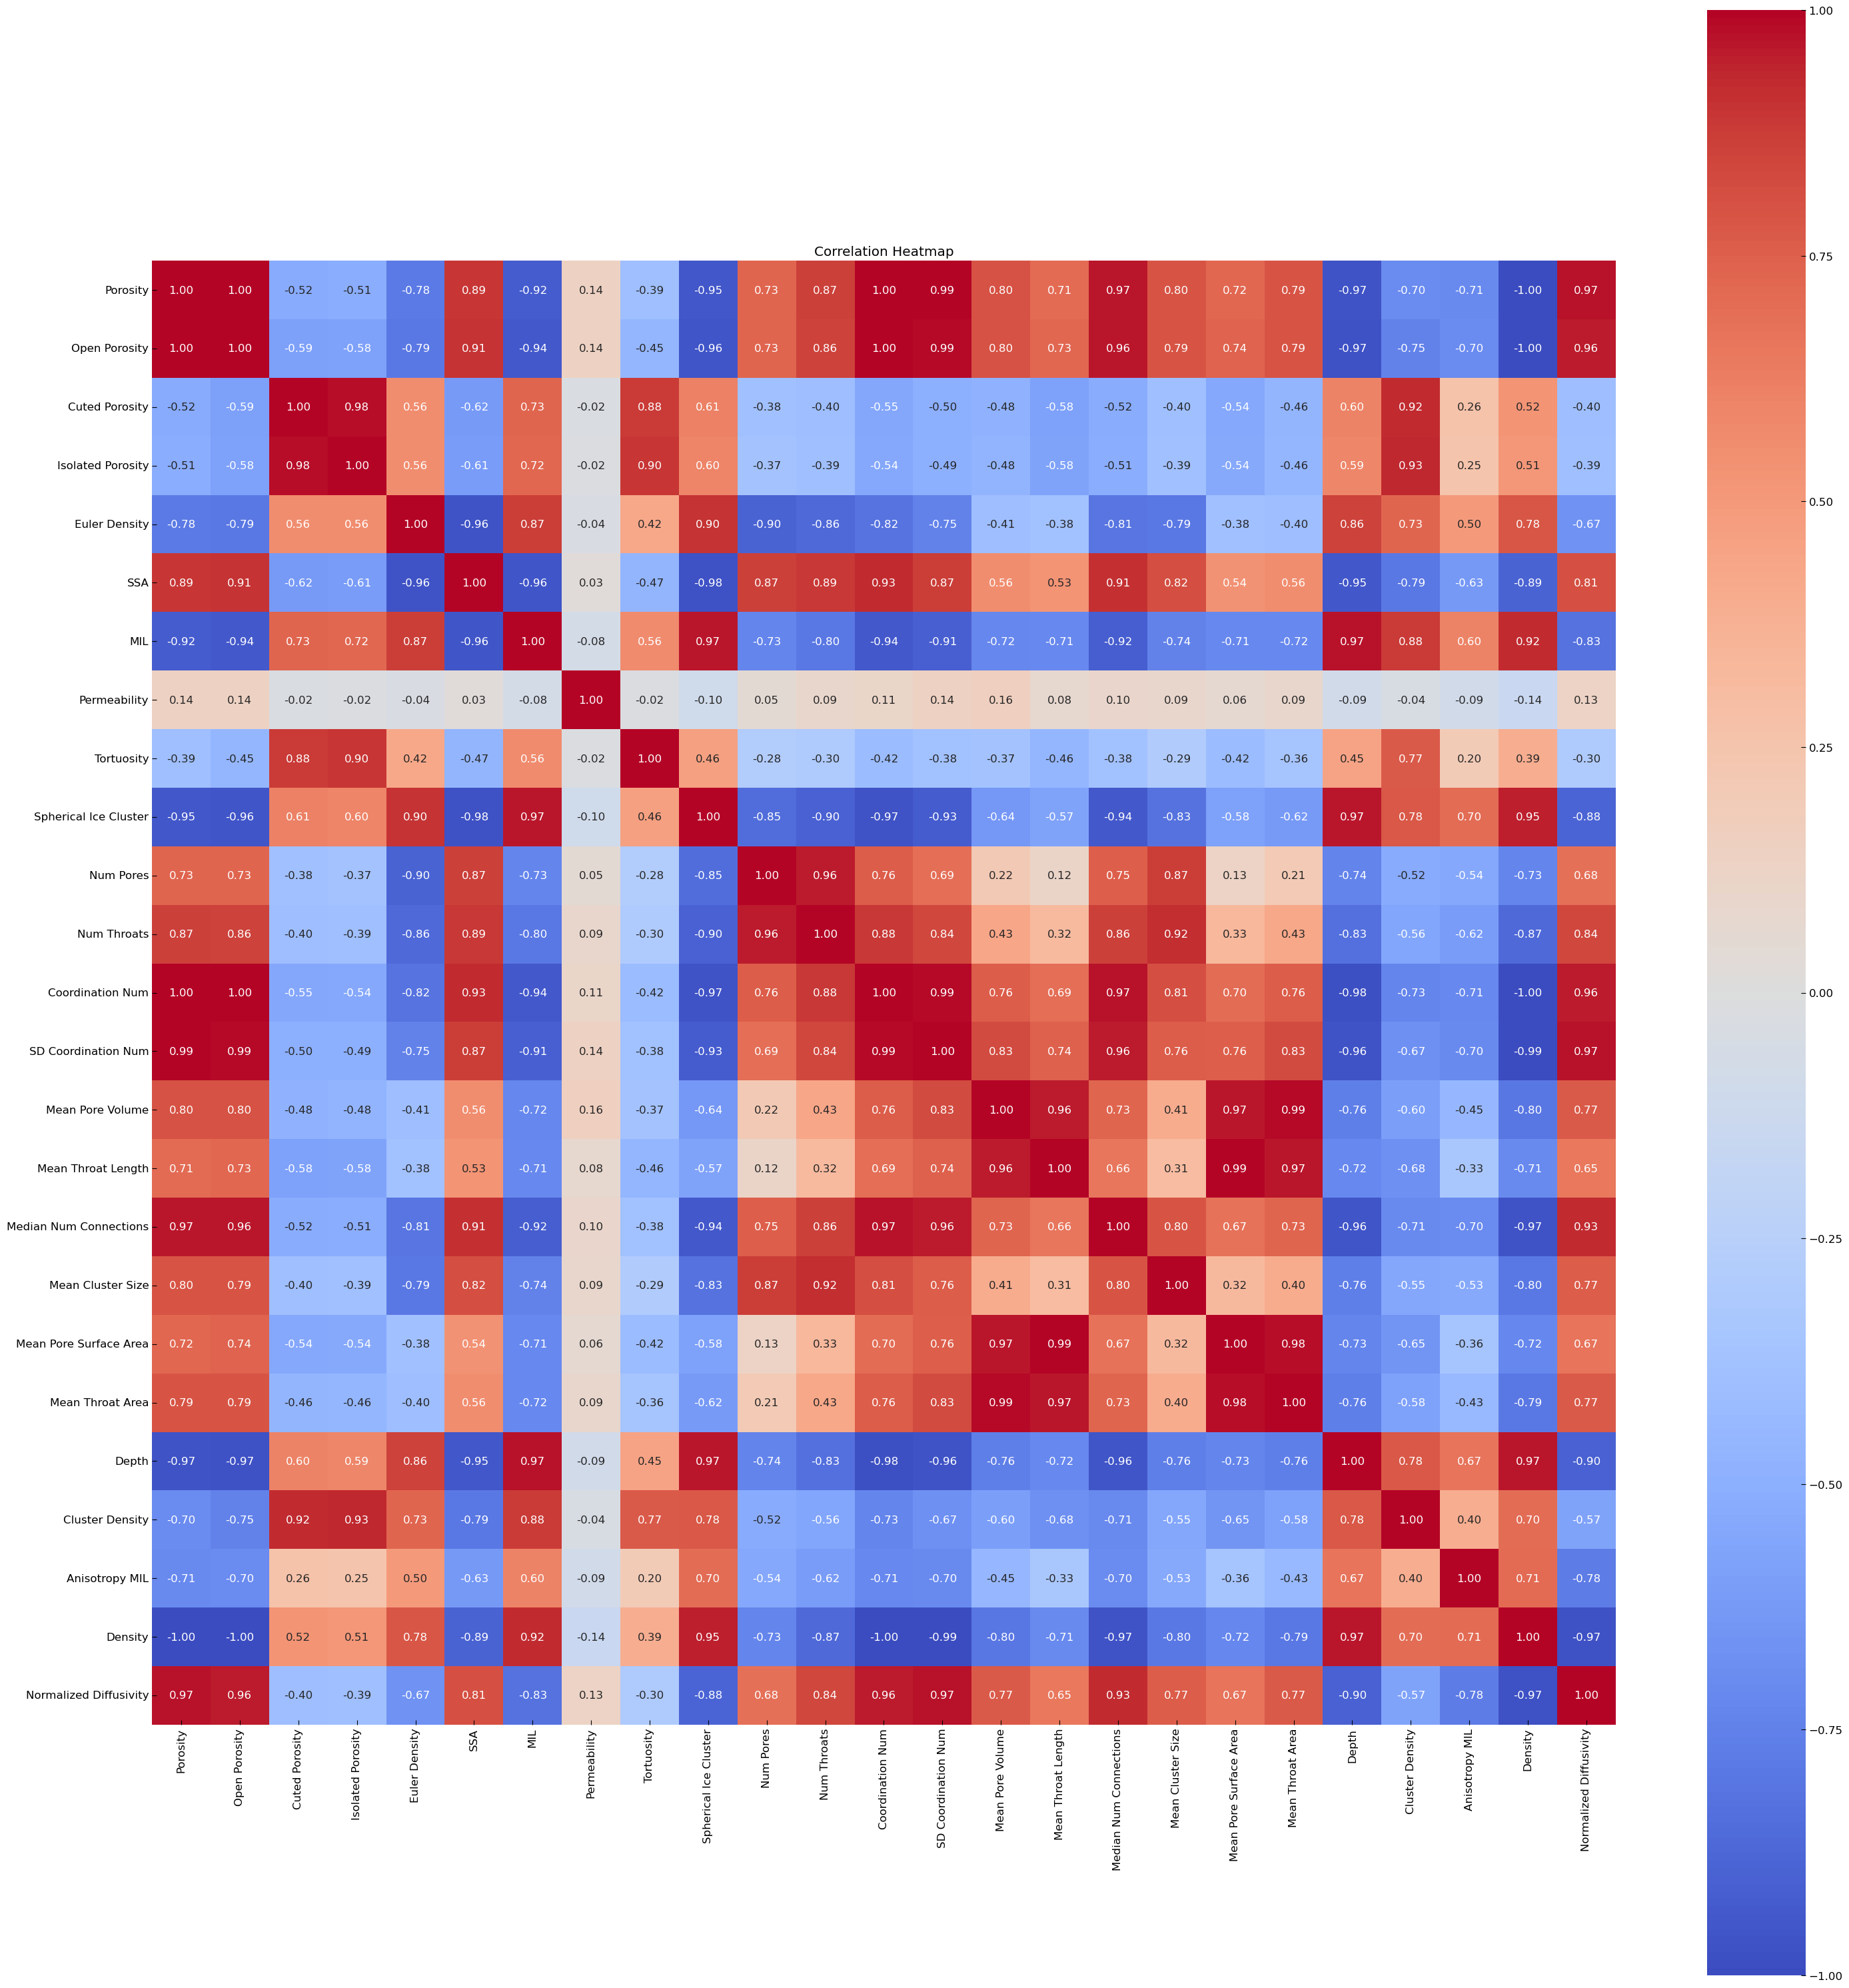

In [29]:


# Set up the matplotlib figure
plt.figure(figsize=(30, 30))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)

# Show the plot
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_1_60.png')

In [19]:
# Load dataset
df = data.copy()

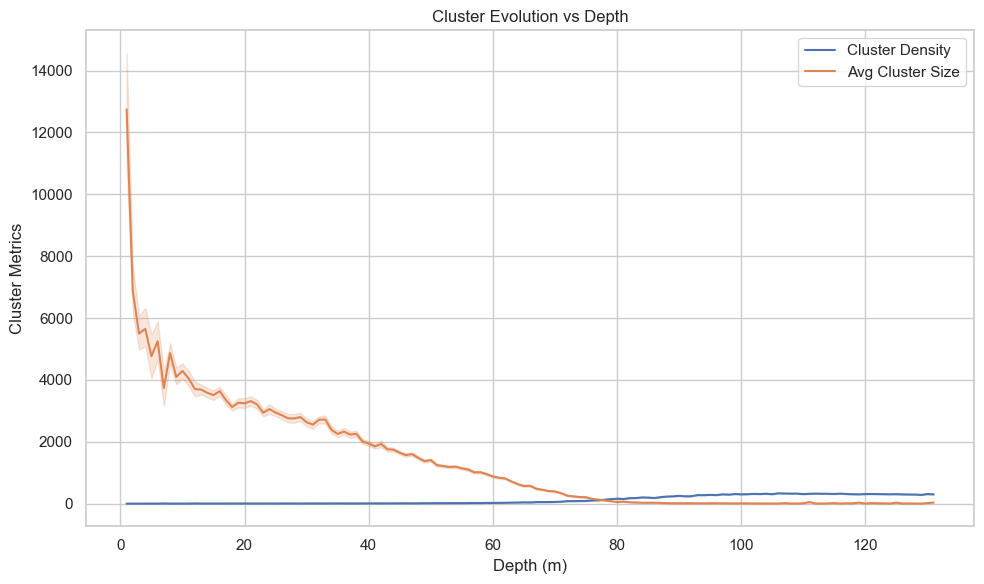

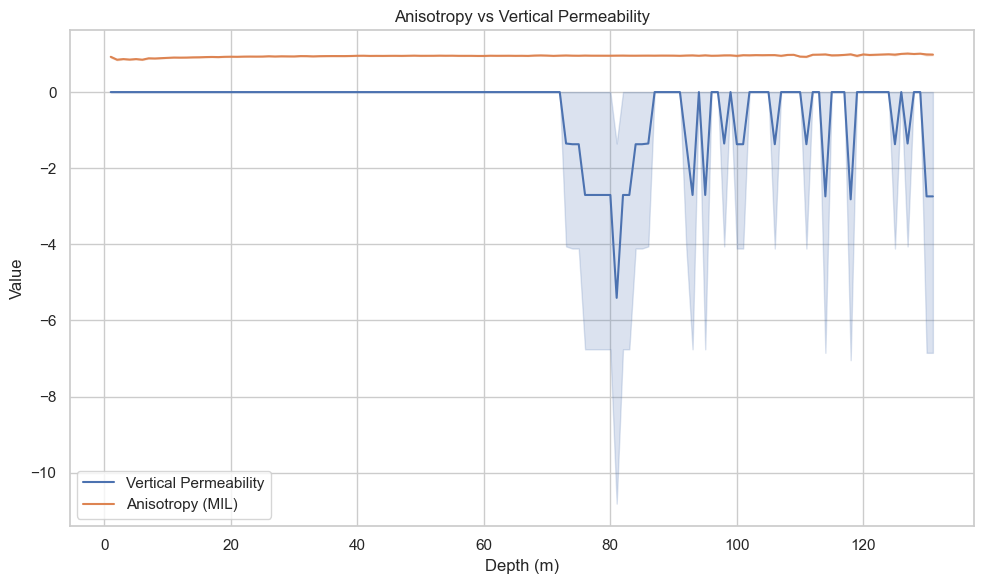

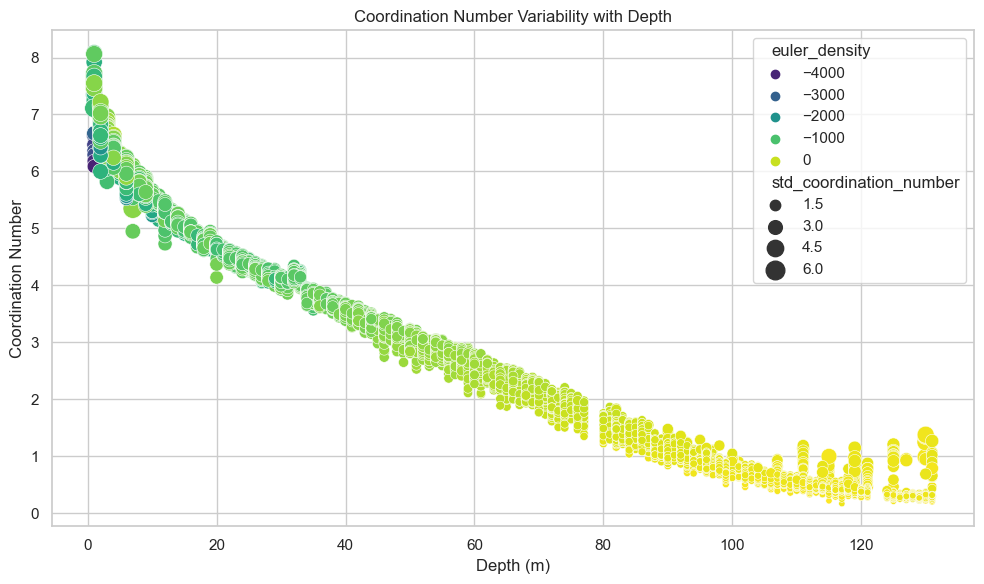

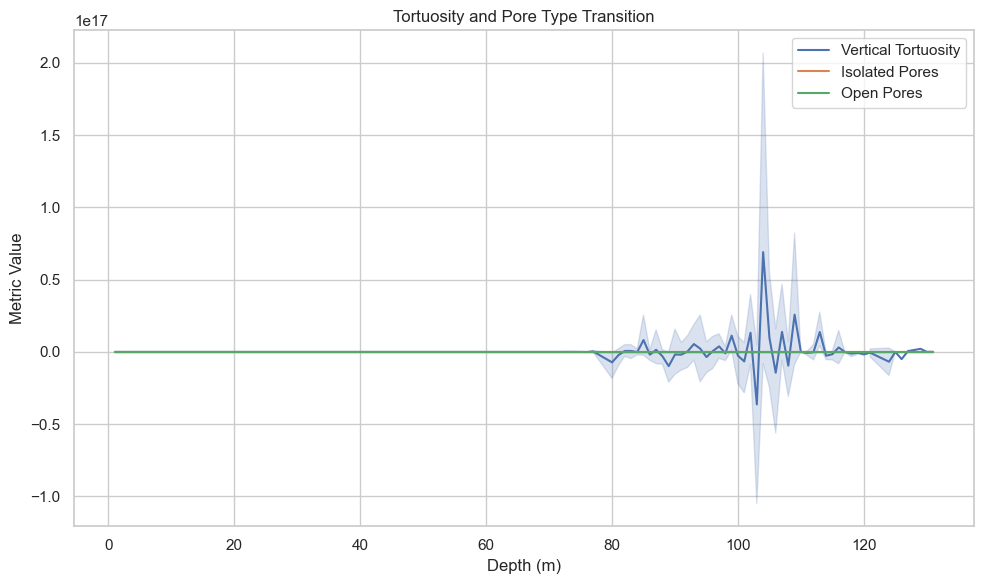

C:\Users\Faramarz\AppData\Local\Temp\ipykernel_10512\3698140174.py:56: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged = df.groupby(pd.cut(df['depth'], bins=depth_bins)).mean()


In [5]:

import plotly.express as px



# Set seaborn theme
sns.set(style="whitegrid")

# HYPOTHESIS 1: Cluster-Based Densification Dynamics
plt.figure(figsize=(10, 6))
sns.lineplot(x="depth", y="cluster_density", label="Cluster Density", data=df)
sns.lineplot(x="depth", y="avg_cluster_size", label="Avg Cluster Size", data=df)
plt.title("Cluster Evolution vs Depth")
plt.xlabel("Depth (m)")
plt.ylabel("Cluster Metrics")
plt.legend()
plt.tight_layout()
plt.show()

# HYPOTHESIS 2: Anisotropy-Controlled Permeability Evolution
plt.figure(figsize=(10, 6))
sns.lineplot(x="depth", y="Perm_z", label="Vertical Permeability", data=df)
sns.lineplot(x="depth", y="anisotropy_MIL", label="Anisotropy (MIL)", data=df)
plt.title("Anisotropy vs Vertical Permeability")
plt.xlabel("Depth (m)")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# HYPOTHESIS 3: Coordination Number and Collapse Indicators
plt.figure(figsize=(10, 6))
sns.scatterplot(x="depth", y="coordination_number", size="std_coordination_number", hue="euler_density", data=df, palette="viridis", sizes=(20, 200))
plt.title("Coordination Number Variability with Depth")
plt.xlabel("Depth (m)")
plt.ylabel("Coordination Number")
plt.tight_layout()
plt.show()

# HYPOTHESIS 4: Tortuosity vs Pore Isolation
plt.figure(figsize=(10, 6))
sns.lineplot(x="depth", y="Tort_z", label="Vertical Tortuosity", data=df)
sns.lineplot(x="depth", y="isolated_pores", label="Isolated Pores", data=df)
sns.lineplot(x="depth", y="open_pores", label="Open Pores", data=df)
plt.title("Tortuosity and Pore Type Transition")
plt.xlabel("Depth (m)")
plt.ylabel("Metric Value")
plt.legend()
plt.tight_layout()
plt.show()

# HYPOTHESIS 5: Multivariate Fingerprinting (PCA-style proxy with radar plot)
import plotly.graph_objects as go

def radar_plot(df, depth_bins):
    averaged = df.groupby(pd.cut(df['depth'], bins=depth_bins)).mean()
    parameters = ['porosity', 'SSA', 'euler_density', 'avg_pore_surface_area', 'avg_pore_diameter', 'avg_throat_diameter']
    
    fig = go.Figure()
    for idx, row in averaged.iterrows():
        fig.add_trace(go.Scatterpolar(
            r=[row[p] for p in parameters],
            theta=parameters,
            fill='toself',
            name=f"{idx}"
        ))
    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True)),
        title="Radar Plot of Microstructural Fingerprint by Depth Bin",
        showlegend=True
    )
    fig.show()

# Define depth bins and call radar plot
depth_bins = [0, 10, 20, 30, 40, 50]
radar_plot(df, depth_bins)


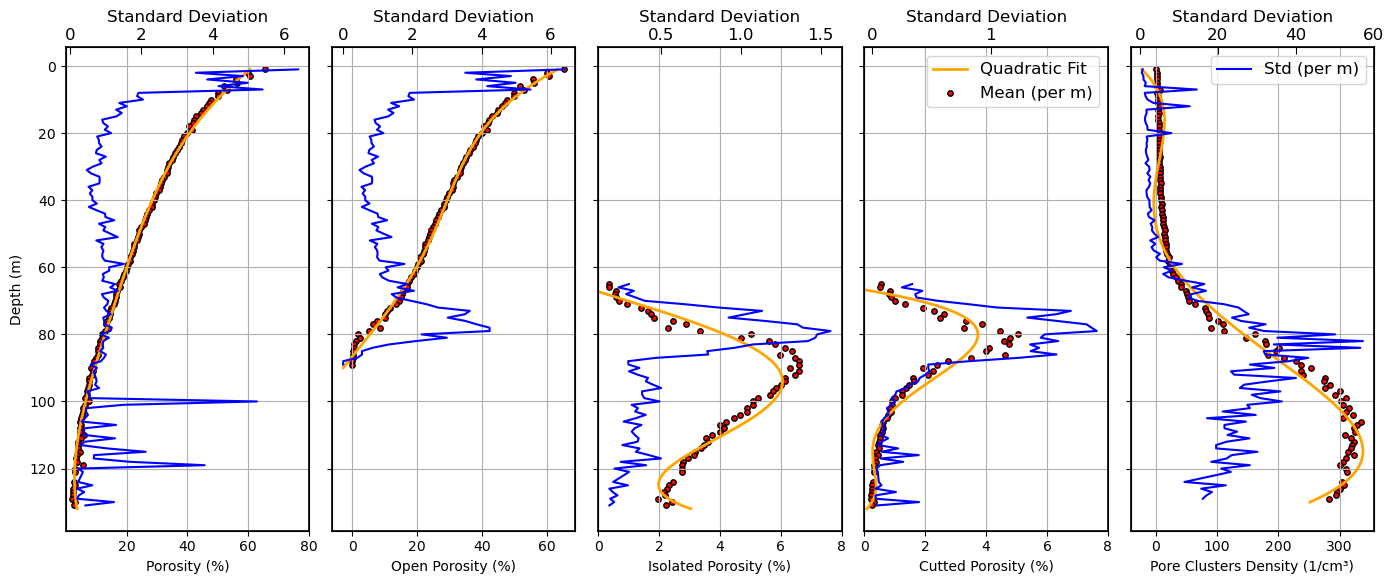

In [4]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()

# Sort data by depth for smooth plotting
df = data.sort_values(by="new_depth").copy()

# Create figure with shared y-axis
fig, axes = plt.subplots(1, 5, figsize=(14, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("porosity", "Porosity (%)"),
    ("open_pores", "Open Porosity (%)"),
    ("isolated_pores", "Isolated Porosity (%)"),
    ("cuted_pores", "Cutted Porosity (%)"),
    ('cluster_density','Pore Clusters Density (1/cm³)')
]

depth = df["new_depth"]

for ax, (col, xlabel) in zip(axes, params):
    x = df[col]
    y = depth
    

    if col == "open_pores":
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 90].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]

    elif col == 'isolated_pores':
        # Subset for depth >= 50
        df_fit = df[df["new_depth"]>65].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        ax.set_xlim(0, 8)
    
    elif col == 'cuted_pores':
        # Subset for depth >= 50
        df_fit = df[df["new_depth"]>65].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        ax.set_xlim(0, 8)

    elif col == "cluster_density":
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 130].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        #ax.set_xlim(0.1, 200)
        
    else:
        x = df[col]
        y = depth
        ax.set_xlim(-2, 75)
        df["depth_bin"] = df["new_depth"].astype(int)
        grouped = df.groupby("depth_bin")[col]
        ax.set_xlim(0.1, 80)
    
    # Residuals and std
    #residuals = x_fit_data - poly(y_fit_data)
    #std = np.std(residuals)
    #ax.fill_betweenx(y_fit, x_fit - std, x_fit + std, color='gray', alpha=0.4, label='±1 Std Dev')

    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

        
        # Fit quadratic
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
        # Generate smooth depth range from 50 to max
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)
    ax.plot(x_fit, y_fit, color='orange', linewidth=2, label='Quadratic Fit')
        # Plot ± std dev band around the bin means
    #ax.fill_betweenx(depth_bins, mean_per_bin - std_per_bin, mean_per_bin + std_per_bin, color='gray', alpha=0.4, label='±1 Std (per m)')
    ax.scatter(mean_per_bin,depth_bins,color='Red', edgecolors='black', s=15, label='Mean (per m)')
    ax_top = ax.twiny()
    ax_top.plot(std_per_bin,depth_bins ,color='Blue',linestyle='-',label = 'Std (per m)')
    ax_top.set_xlabel('Standard Deviation')
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
axes[3].legend()
ax_top.legend()
# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward

#plt.legend(loc='upper right', fontsize=10)
# Layout adjustments
plt.tight_layout()
plt.savefig("fig_porosity.png", dpi=600, bbox_inches='tight')
plt.show()

In [7]:
df.columns

Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'anisotropy_MIL', 'depth_bin'],
      dtype='object')

sph_ice_cluster
euler_density
SSA
anisotropy_MIL


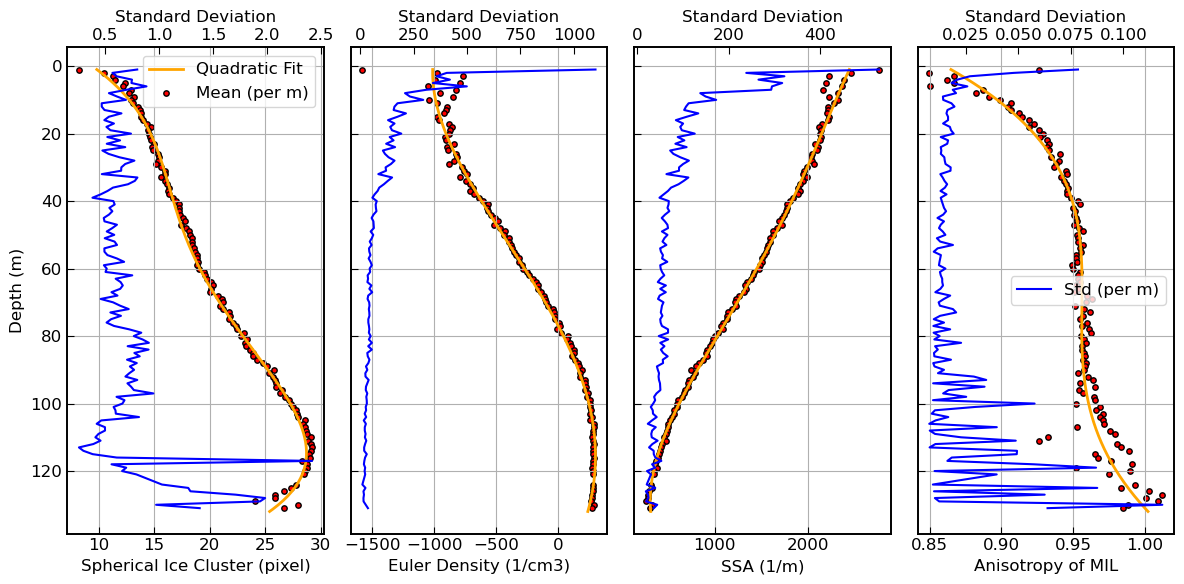

In [5]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()

# Sort data by depth for smooth plotting
df = df.sort_values(by="new_depth")

# Create figure with shared y-axis
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("sph_ice_cluster", "Spherical Ice Cluster (pixel)"),
    ("euler_density", "Euler Density (1/cm3)"),
    ("SSA", "SSA (1/m)"),
    ("anisotropy_MIL", "Anisotropy of MIL")
]


for ax, (col, xlabel) in zip(axes, params):
    print (col)
    x = df[col]
    y = df["new_depth"]
    
    df["depth_bin"] = df["new_depth"].astype(int)
    grouped = df.groupby("depth_bin")[col]

    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

        
        # Fit quadratic
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
        # Generate smooth depth range from 50 to max
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)
    ax.plot(x_fit, y_fit, color='orange', linewidth=2, label='Quadratic Fit')
        # Plot ± std dev band around the bin means
    #ax.fill_betweenx(depth_bins, mean_per_bin - std_per_bin, mean_per_bin + std_per_bin, color='gray', alpha=0.4, label='±1 Std (per m)')
    ax.scatter(mean_per_bin,depth_bins,color='Red', edgecolors='black', s=15, label='Mean (per m)')
    
    ax_top = ax.twiny()
    ax_top.plot(std_per_bin,depth_bins ,color='Blue',label = 'Std (per m)')
    ax_top.set_xlabel('Standard Deviation')

    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward

# Layout adjustments
#plt.legend(loc='upper right', fontsize=10)
axes[0].legend(loc='upper right')
ax_top.legend(loc='best')
plt.tight_layout()
plt.savefig("fig_SIC_SSA_Euler.png", dpi=600, bbox_inches='tight')
plt.show()

In [8]:
df.columns

Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'anisotropy_MIL', 'depth_bin'],
      dtype='object')

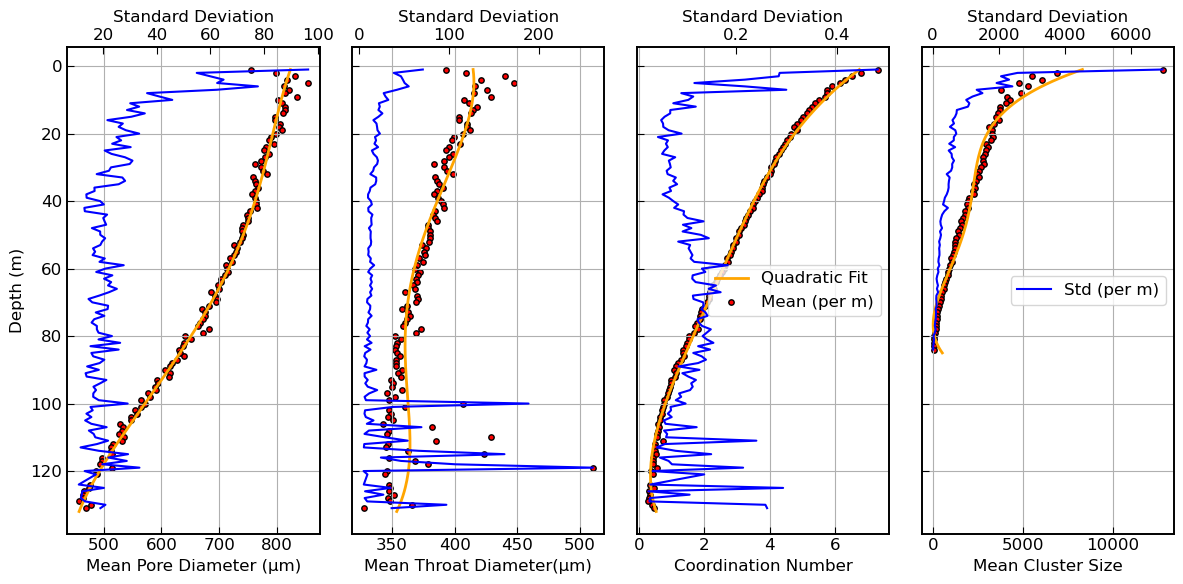

In [6]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()

# Sort data by depth for smooth plotting
df = df.sort_values(by="new_depth")

# Create figure with shared y-axis
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("avg_pore_diameter", "Mean Pore Diameter (μm)"),
    ("avg_throat_diameter", "Mean Throat Diameter(μm)"),
    ("coordination_number", "Coordination Number"),
    ("avg_cluster_size", "Mean Cluster Size")
]

depth = df["new_depth"]

for ax, (col, xlabel) in zip(axes, params):

    
    if col == "avg_cluster_size":
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 85].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
    else:
        x = df[col]
        y = df["new_depth"]
        df["depth_bin"] = df["new_depth"].astype(int)
        grouped = df.groupby("depth_bin")[col]

    
    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

            # Fit quadratic
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
            # Generate smooth depth range from 50 to max
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)
    ax.plot(x_fit, y_fit, color='orange', linewidth=2, label='Quadratic Fit')
            # Plot ± std dev band around the bin means
    #ax.fill_betweenx(depth_bins, mean_per_bin - std_per_bin, mean_per_bin + std_per_bin, color='gray', alpha=0.4, label='±1 Std (per m)')
    ax.scatter(mean_per_bin,depth_bins,color='Red', edgecolors='black', s=15, label='Mean (per m)')
    ax_top = ax.twiny()
    ax_top.plot(std_per_bin,depth_bins ,color='Blue',label = 'Std (per m)')
    ax_top.set_xlabel('Standard Deviation')
    
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward

# Layout adjustments
#plt.legend(loc='lower left', fontsize=10)
axes[2].legend(loc='center right')
ax_top.legend(loc='center right')
plt.tight_layout()
plt.savefig("fig_network.png", dpi=600, bbox_inches='tight')
plt.show()

In [33]:
df.columns

Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'anisotropy_MIL', 'anisotropy_Perm',
       'anisotropy_Tort'],
      dtype='object')

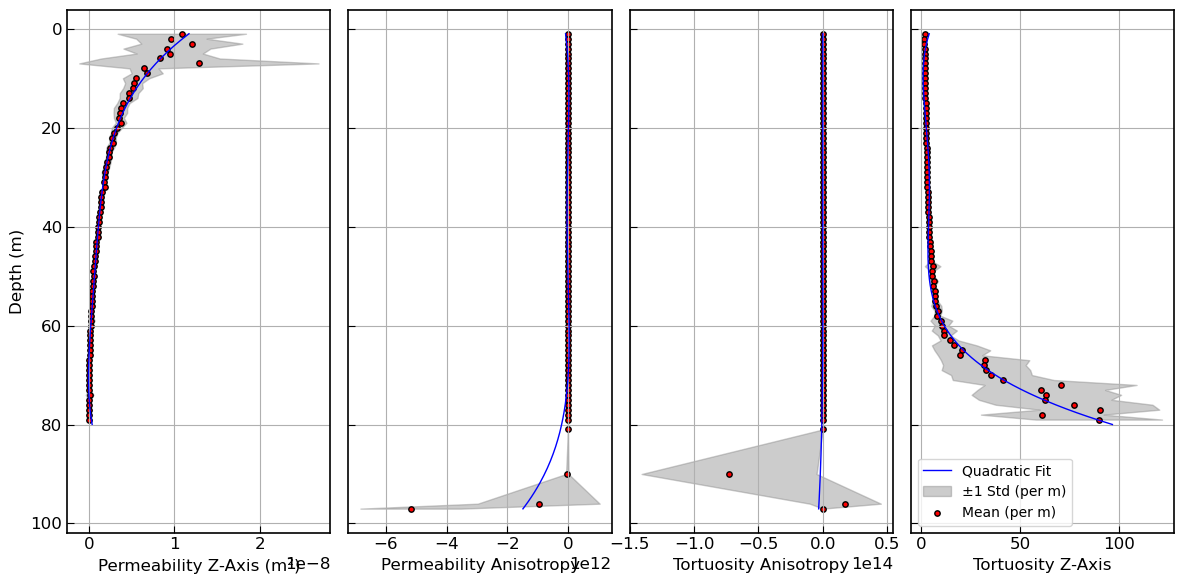

In [7]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()


# Create figure with shared y-axis
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("Perm_z", "Permeability Z-Axis (m²)"),
    ("anisotropy_Perm", "Permeability Anisotropy"),
    ("anisotropy_Tort", "Tortuosity Anisotropy"),
    ("Tort_z", "Tortuosity Z-Axis")
    
]

depth = df["new_depth"]

for ax, (col, xlabel) in zip(axes, params):

    
    if col == "Tort_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        #df = df[df["new_depth"] < 90]
        df = df[df["new_depth"] < 100]
        df = df[df["Tort_z"] > 1]
        df = df[df["Tort_z"] < 150]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 80].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
        
        
    elif col == "Perm_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        #df = df[df["new_depth"] < 90]
        df = df[df["new_depth"] < 100]
        df = df[df["Perm_z"] > 5e-12]
        df = df[df["Perm_z"] < 5e-8]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 80].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
    else:
        x = df[col]
        y = df["new_depth"]
        df["depth_bin"] = df["new_depth"].astype(int)
        grouped = df.groupby("depth_bin")[col]

    
    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

            # Fit quadratic
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
            # Generate smooth depth range from 50 to max
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)
    ax.plot(x_fit, y_fit, color='blue', linewidth=1, label='Quadratic Fit')
            # Plot ± std dev band around the bin means
    ax.fill_betweenx(depth_bins, mean_per_bin - std_per_bin, mean_per_bin + std_per_bin, color='gray', alpha=0.4, label='±1 Std (per m)')
    ax.scatter(mean_per_bin,depth_bins,color='Red', edgecolors='black', s=15, label='Mean (per m)')
    
    
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward

# Layout adjustments
plt.legend(loc='lower left', fontsize=10)

plt.tight_layout()
plt.savefig("fig_transport.png", dpi=600, bbox_inches='tight')
plt.show()

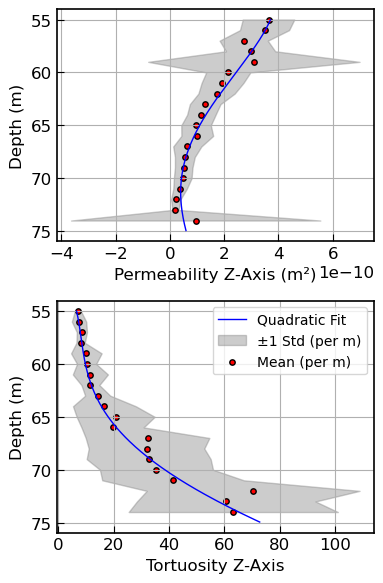

In [43]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()


# Create figure with shared y-axis
#fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharey=True)
fig, axes = plt.subplots(2, 1, figsize=(4, 6))
# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("Perm_z", "Permeability Z-Axis (m²)"),
    ("Tort_z", "Tortuosity Z-Axis")
    
]

depth = df["new_depth"]

for ax, (col, xlabel) in zip(axes, params):

    
    if col == "Tort_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        df = df[df["new_depth"] < 75]
        df = df[df["new_depth"] > 55]
        df = df[df["Tort_z"] > 1]
        df = df[df["Tort_z"] < 150]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] > 55].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
        
        
    elif col == "Perm_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        df = df[df["new_depth"] < 75]
        df = df[df["new_depth"] > 55]
        
        df = df[df["Perm_z"] > 5e-12]
        df = df[df["Perm_z"] < 5e-8]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] > 55].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
    else:
        x = df[col]
        y = df["new_depth"]
        df["depth_bin"] = df["new_depth"].astype(int)
        grouped = df.groupby("depth_bin")[col]

    
    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

            # Fit quadratic
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
            # Generate smooth depth range from 50 to max
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)
    ax.plot(x_fit, y_fit, color='blue', linewidth=1, label='Quadratic Fit')
            # Plot ± std dev band around the bin means
    ax.fill_betweenx(depth_bins, mean_per_bin - std_per_bin, mean_per_bin + std_per_bin, color='gray', alpha=0.4, label='±1 Std (per m)')
    ax.scatter(mean_per_bin,depth_bins,color='Red', edgecolors='black', s=15, label='Mean (per m)')
    
    
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[1].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward
axes[1].invert_yaxis()
# Layout adjustments
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig("fig_transport_zoom.png", dpi=600, bbox_inches='tight')
plt.show()

In [5]:
df = data.copy()
df.columns

Index(['name', 'number_of_regions', 'starting_layer', 'ending_layer', 'depth',
       'sample_volume', 'porosity', 'open_pores', 'cuted_pores',
       'isolated_pores', 'euler_density', 'SSA', 'MIL_x', 'MIL_y', 'MIL_z',
       'Perm_x', 'Perm_y', 'Perm_z', 'Tort_x', 'Tort_y', 'Tort_z',
       'sph_ice_cluster', 'num_pores', 'num_throats', 'coordination_number',
       'std_coordination_number', 'avg_pore_volume', 'avg_pore_diameter',
       'avg_throat_diameter', 'avg_throat_length', 'max_connections',
       'median_connections', 'num_cluster', 'max_cluster_size',
       'avg_cluster_size', 'avg_pore_surface_area', 'avg_throat_area',
       'new_depth', 'cluster_density', 'anisotropy_MIL', 'anisotropy_Perm',
       'anisotropy_Tort', 'density'],
      dtype='object')

In [ ]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()


# Create figure with shared y-axis
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})

# Plot configs
params = [
    ("Perm_z", "Permeability Z-Axis (m²)"),
    ("anisotropy_Perm", "Permeability Anisotropy"),
    ("anisotropy_Tort", "Tortuosity Anisotropy"),
    ("Tort_z", "Tortuosity Z-Axis")
    
]

depth = df["new_depth"]

for ax, (col, xlabel) in zip(axes, params):

    
    if col == "Tort_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        #df = df[df["new_depth"] < 90]
        df = df[df["new_depth"] < 100]
        df = df[df["Tort_z"] > 1]
        df = df[df["Tort_z"] < 150]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 80].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
        
        
    elif col == "Perm_z":
        
        df = data.copy()
        # Sort data by depth for smooth plotting
        df = df.sort_values(by="new_depth")
        #df = df[df["new_depth"] < 90]
        df = df[df["new_depth"] < 100]
        df = df[df["Perm_z"] > 5e-12]
        df = df[df["Perm_z"] < 5e-8]
        
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 80].copy()
        y = df_fit["new_depth"]
        x = df_fit[col]
        df_fit["depth_bin"] = df_fit["new_depth"].astype(int)
        grouped = df_fit.groupby("depth_bin")[col]
        
    else:
        x = df[col]
        y = df["new_depth"]
        df["depth_bin"] = df["new_depth"].astype(int)
        grouped = df.groupby("depth_bin")[col]

    
    mean_per_bin = grouped.mean()
    std_per_bin = grouped.std()
    depth_bins = mean_per_bin.index

            # Fit quadratic
    coeffs = np.polyfit(y, x, deg=4)
    poly = np.poly1d(coeffs)
            # Generate smooth depth range from 50 to max
    y_fit = np.linspace(y.min(), y.max(), 200)
    x_fit = poly(y_fit)
    ax.plot(x_fit, y_fit, color='blue', linewidth=1, label='Quadratic Fit')
            # Plot ± std dev band around the bin means
    ax.fill_betweenx(depth_bins, mean_per_bin - std_per_bin, mean_per_bin + std_per_bin, color='gray', alpha=0.4, label='±1 Std (per m)')
    ax.scatter(mean_per_bin,depth_bins,color='Red', edgecolors='black', s=15, label='Mean (per m)')
    
    
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward

# Layout adjustments
plt.legend(loc='lower left', fontsize=10)

plt.tight_layout()
plt.savefig("fig_transport.png", dpi=600, bbox_inches='tight')
plt.show()

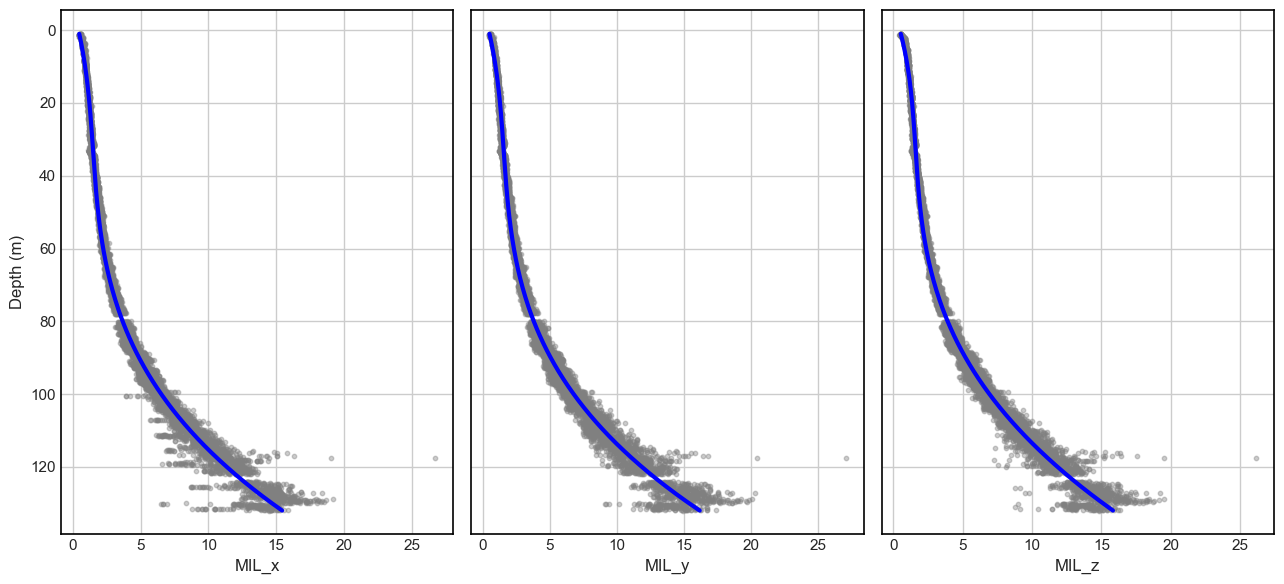

In [12]:
# Keep only necessary columns and drop NaNs
#df = df[["new_depth", "porosity", "SSA", "MIL_z"]].dropna()

# Sort data by depth for smooth plotting
df = df.sort_values(by="new_depth")

# Create figure with shared y-axis
fig, axes = plt.subplots(1, 3, figsize=(13, 6), sharey=True)

# Apply academic-style formatting
plt.rcParams.update({
    "font.size": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5
})
'MIL_x', 'MIL_y', 'MIL_z'
# Plot configs
params = [
    ("MIL_x", "MIL_x"),
    ("MIL_y", "MIL_y"),
    ("MIL_z", "MIL_z")
]

depth = df["new_depth"]

for ax, (col, xlabel) in zip(axes, params):
    x = df[col]
    y = depth
    
    # Scatter plot
    ax.scatter(x, y, color='gray', alpha=0.4, s=10, label='Data')

        # Trend line
    if col == "open_pores":
        # Subset for depth >= 50
        df_fit = df[df["new_depth"] < 90]
        y_fit_data = df_fit["new_depth"]
        x_fit_data = df_fit[col]
        # Fit quadratic
        coeffs = np.polyfit(y_fit_data, x_fit_data, deg=3)
        poly = np.poly1d(coeffs)
        # Generate smooth depth range from 50 to max
        y_fit = np.linspace(y_fit_data.min(), y_fit_data.max(), 200)
        x_fit = poly(y_fit)
        ax.plot(x_fit, y_fit, color='blue', linewidth=3, label='Quadratic Fit (depth ≥ 50)')
        ax.set_xlim(-2, 100)
        
    elif col == 'isolated_pores':
        df_fit = df[df["new_depth"] >= 65]
        y_fit_data = df_fit["new_depth"]
        x_fit_data = df_fit[col]
        
        # Fit quadratic
        coeffs = np.polyfit(y_fit_data, x_fit_data, deg=3)
        poly = np.poly1d(coeffs)

        # Generate smooth depth range from 50 to max
        y_fit = np.linspace(y_fit_data.min(),  y_fit_data.max(), 200)
        x_fit = poly(y_fit)
        ax.plot(x_fit, y_fit, color='blue', linewidth=3, label='Quadratic Fit (depth ≥ 50)')
        #ax.set_xlim(-0.1, 10)
    else:
        # Quadratic fit
        coeffs = np.polyfit(x=y, y=x, deg=4)        # x vs depth (i.e., x = f(y))
        poly = np.poly1d(coeffs)
        y_fit = np.linspace(y.min(), y.max(), 200)  # Smooth y values
        x_fit = poly(y_fit)
    
    # Plot trend line
        ax.plot(x_fit, y_fit, color='blue', linewidth=3, label='Quadratic Fit')
        #ax.set_xlim(-2, 100)
    
    # Labels and grid
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

# Shared y-label and inverted axis
axes[0].set_ylabel("Depth (m)")
axes[0].invert_yaxis()  # Depth increases downward

# Layout adjustments
plt.tight_layout()
plt.savefig("MIL.png", dpi=600, bbox_inches='tight')
plt.show()

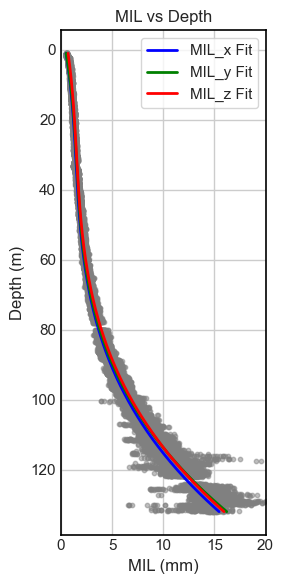

In [13]:
fig, ax = plt.subplots(figsize=(3, 6))

for mil_col, label, color in [("MIL_x", "MIL_x", 'blue'), 
                              ("MIL_y", "MIL_y", 'green'), 
                              ("MIL_z", "MIL_z", 'red')]:
    x = df["new_depth"]
    y = df[mil_col]
    
    # Scatter
    ax.scatter( y, x,color='gray', s=10, alpha=0.5)

    # Fit and plot quadratic trend
    coeffs = np.polyfit(x, y, deg=3)
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(x.min(), x.max(), 300)
    y_fit = poly(x_fit)
    ax.plot( y_fit,x_fit, color=color, linewidth=2, label=f'{label} Fit')

# Style
ax.set_xlabel("MIL (mm)")
ax.set_ylabel("Depth (m)")
ax.set_title("MIL vs Depth")
ax.grid(True)
ax.legend()
ax.invert_yaxis()  # Optional: reverse depth direction
ax.set_xlim(0, 20)  # Optional
# ax.set_ylim(0, 5)    # Optional

plt.tight_layout()
plt.savefig("MIL_vs_depth.png", dpi=600, bbox_inches='tight')
plt.show()


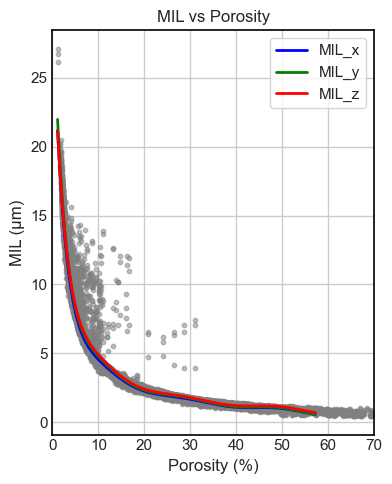

In [14]:
fig, ax = plt.subplots(figsize=(4, 5))

for mil_col, label, color in [("MIL_x", "MIL_x", 'blue'), 
                              ("MIL_y", "MIL_y", 'green'), 
                              ("MIL_z", "MIL_z", 'red')]:
    
    # Full scatter
    ax.scatter(df["porosity"], df[mil_col], color='gray', s=10, alpha=0.5)
    
    # Subset data for trend line (porosity < 60)
    mask = df["porosity"] < 100
    x_fit_data = df.loc[mask, "porosity"]
    y_fit_data = df.loc[mask, mil_col]
    
    # Fit and plot quadratic trend line
    coeffs = np.polyfit(x_fit_data, y_fit_data, deg=10)
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(x_fit_data.min(), x_fit_data.max(), 300)
    y_fit = poly(x_fit)

    ax.plot(x_fit[:220], y_fit[:220], color=color, linewidth=2, label=f'{label}')

# Formatting
ax.set_xlabel("Porosity (%)")
ax.set_ylabel("MIL (µm)")
ax.set_title("MIL vs Porosity")
ax.grid(True)
ax.legend()
ax.set_xlim(0, 70)   # Full porosity range for scatter
# ax.set_ylim(0, 5)    # Optional y-limit

plt.tight_layout()
plt.savefig("MIL_vs_porosity_limited_fit.png", dpi=600, bbox_inches='tight')
plt.show()


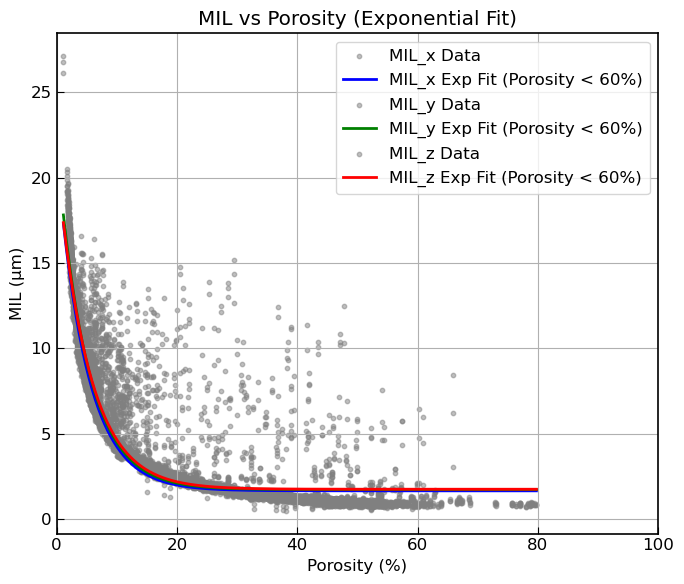

In [100]:

# Define offset exponential function
def exp_offset(x, a, b, c):
    return a * np.exp(b * x) + c
    
# Start plotting
fig, ax = plt.subplots(figsize=(7, 6))

for mil_col, label, color in [("MIL_x", "MIL_x", 'blue'), 
                              ("MIL_y", "MIL_y", 'green'), 
                              ("MIL_z", "MIL_z", 'red')]:
    
    # Full scatter plot
    ax.scatter(df["porosity"], df[mil_col], color='gray', s=10, alpha=0.5, label=f'{label} Data')

    # Subset for porosity < 60
    mask = df["porosity"] < 100
    x_data = df.loc[mask, "porosity"]
    y_data = df.loc[mask, mil_col]
    
    try:
        popt, _ = curve_fit(exp_offset, x_data, y_data, p0=(1, 0.01, 0), maxfev=10000)
        x_fit = np.linspace(x_data.min(), x_data.max(), 300)
        y_fit = exp_offset(x_fit, *popt)
        ax.plot(x_fit, y_fit, color=color, linewidth=2, label=f'{label} Exp Fit (Porosity < 60%)')
    except RuntimeError:
        print(f"Could not fit exponential with offset for {label}")

# Final formatting
ax.set_xlabel("Porosity (%)")
ax.set_ylabel("MIL (µm)")
ax.set_title("MIL vs Porosity (Exponential Fit)")
ax.grid(True)
ax.legend()
ax.set_xlim(0, 100)  # Full porosity range
# ax.set_ylim(0, 5)  # Optional

plt.tight_layout()
#plt.savefig("MIL_vs_porosity_exponential_fit.png", dpi=600, bbox_inches='tight')
plt.show()
